## This version uses the correct matrices in the linear equation. It however seems to give nearly indentical results to my previous version.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
x = np.arange(-15, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

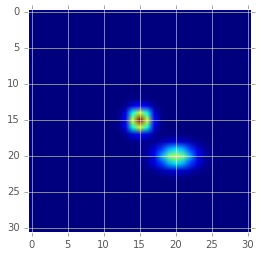

In [3]:
import scipy.stats

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = scipy.stats.multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

#x, y = np.mgrid[-15:16:1, -15:16:1]
#grid = np.dstack((x, y))
g1 = gaussian2d(grid) + gaussian2d(grid, [5,5], [3,1])
plt.imshow(g1)

## Update: it looks like the actual code uses chebyshev1 polynomials!

Note these are essentially the same but with different scale factors.

In [4]:
# This code works, but I think the next cell is faster.
from numpy.polynomial.chebyshev import chebgrid2d

h0 = chebgrid2d(x, y, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebgrid2d(x, y, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 0, 1]])

In [5]:
from numpy.polynomial.chebyshev import chebval2d
h0 = chebval2d(x0, y0, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebval2d(x0, y0, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 0, 1]])

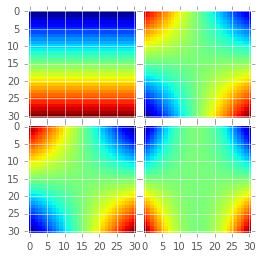

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
igrid[0].imshow(h0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(h1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(h2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(h3, interpolation='none')  # The AxesGrid object work as a list of axes.

In [7]:
## The following code does exactly the same as the above:
from numpy.polynomial.chebyshev import chebval
def chebval2d_try(x, y, xord, yord):
    cx = chebval(x, xord)
    cy = chebval(y, yord)
    h0 = np.outer(cx, cy)
    return h0

if False:
    #h0 = chebval2d_try(x, y, [1, 0, 0], [0, 1, 0])
    h0 = chebval2d_try(x, y, [0, 1, 0], [0, 1, 0])
    #h0 = chebval2d_try(x, y, [0, 1, 0], [0, 0, 1])
    print h0.shape
    plt.imshow(h0)

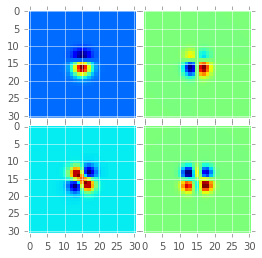

In [8]:
gh0 = gaussian2d(grid, s=[3., 3.]) * h0
gh1 = gaussian2d(grid, s=[3., 3.]) * h1
gh2 = gaussian2d(grid, s=[3., 3.]) * h2
gh3 = gaussian2d(grid, s=[3., 3.]) * h3
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
extent = (x0.min(), x0.max(), y0.min(), y0.max())
igrid[0].imshow(gh0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(gh1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(gh2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(gh3, interpolation='none')  # The AxesGrid object work as a list of axes.

## Generate AL basis funcs now...

use same parameters as from the stack.

TBD: is a degGauss of 2 mean it goes up to order 2 (i.e. $x^2$)? Or is it 2 orders so it only goes up to linear ($x$)? Probably the former, so that's what we'll use.

In [9]:
# Parameters from stack
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
betaGauss = 1   # in the Becker et al. paper sigGauss is 1 but PSF is more like 2 pixels?
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
#degGauss = [6, 4, 2]

def chebGauss2d(x, y, grid, m=None, s=None, ord=[0,0], beta=1., verbose=False):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    coefLen = np.max(ord)+1
    coef0 = np.zeros(coefLen)
    coef0[ord[0]] = 1
    coef1 = np.zeros(coefLen)
    coef1[ord[1]] = 1
    if verbose:
        print s, ord, coef0, coef1
    ga = gaussian2d(grid, m, np.array(s)/beta)
    ch = chebval2d(x, y, c=np.outer(coef0, coef1))
    return ch * ga

In [10]:
basis = [chebGauss2d(x0, y0, grid, m=[0,0], s=[sig0,sig1], ord=[deg0,deg1], beta=betaGauss, verbose=True) for i0,sig0 in enumerate(sigGauss) for i1,sig1 in enumerate(sigGauss) for deg0 in range(degGauss[i0]+1) for deg1 in range(degGauss[i1]+1)]
print len(basis), basis[0].shape, x0.shape, grid.shape, basis[0].reshape(x0.shape).shape

[0.75, 0.75] [0, 0] [ 1.] [ 1.]
[0.75, 0.75] [0, 1] [ 1.  0.] [ 0.  1.]
[0.75, 0.75] [0, 2] [ 1.  0.  0.] [ 0.  0.  1.]
[0.75, 0.75] [0, 3] [ 1.  0.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [0, 4] [ 1.  0.  0.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [1, 0] [ 0.  1.] [ 1.  0.]
[0.75, 0.75] [1, 1] [ 0.  1.] [ 0.  1.]
[0.75, 0.75] [1, 2] [ 0.  1.  0.] [ 0.  0.  1.]
[0.75, 0.75] [1, 3] [ 0.  1.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [1, 4] [ 0.  1.  0.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [2, 0] [ 0.  0.  1.] [ 1.  0.  0.]
[0.75, 0.75] [2, 1] [ 0.  0.  1.] [ 0.  1.  0.]
[0.75, 0.75] [2, 2] [ 0.  0.  1.] [ 0.  0.  1.]
[0.75, 0.75] [2, 3] [ 0.  0.  1.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [2, 4] [ 0.  0.  1.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [3, 0] [ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[0.75, 0.75] [3, 1] [ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[0.75, 0.75] [3, 2] [ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[0.75, 0.75] [3, 3] [ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[0.75, 0.75] [3, 4] [ 0.

In [11]:
print len(basis), basis[0].shape, basis[0].reshape(x0.shape).shape, 31*31
basis2 = np.dstack(basis).T  # put the bases into an array
print basis2.shape, basis2[0].shape, basis2[0].reshape(x0.shape).shape
print basis[0].min(), basis[0].max(), basis2.min(), basis2.max()

121 (31, 31) (31, 31) 961
(121, 31, 31) (31, 31) (31, 31)
1.0924820179e-131 0.212206590789 -14.1624248714 14.1624248714


Make the two "images". `im1` is the template, `im2` is the science image.

NOTE: having sources near the edges really messes up the fitting (probably because of the convolution). So make sure no sources are near the edge.

NOTE: also it seems that having the variable source with a large flux increase also messes up the fitting (seems to lead to overfitting -- perhaps to the source itself). This might be fixed by adding more constant sources.

280 -0.187845065956 -11.0950094076
DescribeResult(nobs=261121, minmax=(-1499.5035483979973, 413.1833949903874), mean=-5.2772891270733671e-05, variance=3070.5345621123342, skewness=-9.083236777525126, kurtosis=127.54863408195362)


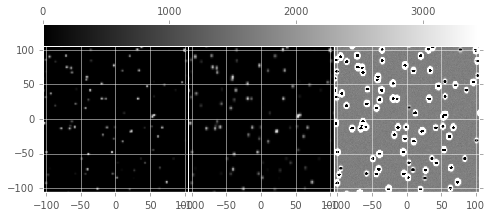

In [12]:
np.random.seed(66)

xim = np.arange(-255, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))
n_sources = 500
fluxes = np.random.uniform(50, 30000, n_sources)
xposns = np.random.uniform(xim.min()+5, xim.max()-5, n_sources)
yposns = np.random.uniform(yim.min()+5, yim.max()-5, n_sources)

# Make the source closest to the center of the image the one that increases in flux
ind = np.argmin(xposns**2. + yposns**2.)
print ind, xposns[ind], yposns[ind]

sig1 = 0.2  # sigma of template
sig2 = 0.2  # sigma of science image
im1 = np.random.normal(scale=sig1, size=x0im.shape)
im2 = np.random.normal(scale=sig2, size=x0im.shape)

psf1 = 1.6 # sigma in pixels im1 will be template
psf2 = 2.2 # sigma in pixels im2 will be science image. make the psf in this image slighly offset and elongated
offset = 0.0  # astrometric offset (pixels) between the two images
for i in range(n_sources):
    im1 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i],yposns[i]], s=[psf1, psf1])
    im2 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i]+offset,yposns[i]+offset], s=[psf2, psf2*1.5])
    if i == ind:
        im2 += (fluxes[i]/50.) * gaussian2d(imgrid, m=[xposns[i]+offset,yposns[i]+offset], s=[psf2, psf2*1.5])

fig = plt.figure(1, (9, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow((im2-im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10))
igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - im1, axis=None)

Convolve im1 (template) with the basis functions, and make these the *new* bases.

In [13]:
import scipy.signal

basis2 = [scipy.signal.fftconvolve(im1, b, mode='same') for b in basis]
print len(basis2), basis2[0].shape

basis2a = np.vstack([b.flatten() for b in basis2]).T
print basis2a.shape, im2.flatten().shape

121 (511, 511)
(261121, 121) (261121,)


Do the linear fit to compute the matching kernel. The resulting fit is the convolved diffim.

[  5.72775391e+01   2.73683196e+02   3.13622183e+02   7.36295619e-03
  -3.71293787e-01   7.90382373e+02  -9.14712815e-02   7.99208914e+01
   7.13067940e-03   1.81809863e+00   3.63822912e+02   2.73334508e+01
   6.72444815e+01   7.15436835e-03   7.62366839e-01  -1.52282424e-02
  -1.28759870e-02   5.88342967e-02  -2.57095531e-04  -4.27617468e-04
  -8.47709017e-01   6.14489305e-01   6.26768427e-01  -9.69836483e-05
  -3.17932552e-03   1.53529192e+01  -3.68850441e+02  -4.04476310e+02
  -9.37367791e-01   1.58456004e-01  -8.25479862e-01   3.17581552e+01
   1.92252309e+01   2.49126494e+01  -7.55232249e-03  -6.18905222e-03
   2.61601489e-02   3.64136649e-01  -2.69594786e-01  -2.44709231e-01
  -3.43521573e+02   5.42324442e+01   1.42455697e+01   1.31262516e-02
   3.42346090e-02  -1.52422377e-01   5.67917486e+00  -1.03377358e+00
  -3.23191853e-01  -2.84521086e-04  -2.38950030e-04   1.05921687e-03
  -2.97641727e-03   2.51971899e-03   1.79379015e-03  -2.72939157e+02
  -1.82424856e+00   4.81216805e+01

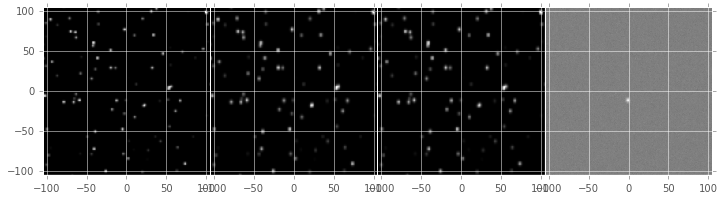

In [14]:
pars, resid, _, _ = np.linalg.lstsq(basis2a, im2.flatten())
print pars
fit = (pars * basis2a).sum(1).reshape(im2.shape)
print resid, np.sum((im2 - fit.reshape(im2.shape))**2), np.sum((im2 - im1)**2)
print basis2a.shape, fit.shape

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow((im2 - fit)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10))
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit, axis=None)

Look at the resulting matching kernel by multiplying the fitted parameters times the original basis funcs. and test that actually convolving it with the template gives us a good subtraction.

(121,) (961, 121)
0.999989985885


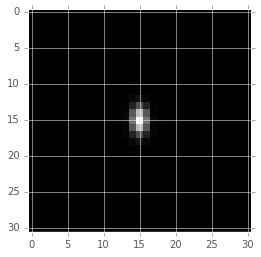

In [15]:
kbasis = np.vstack([b.flatten() for b in basis]).T
print pars.shape, kbasis.shape
kfit = (pars * kbasis).sum(1).reshape(basis[0].shape)
print kfit.sum()
kfit /= kfit.sum()  # this is necessary if the variable source changes a lot - prevent the kernel from incorporating that change in flux
plt.imshow(kfit, interpolation='none', cmap='gray')  # this plots the matching kernel

Compare the convolved template to the science image. Also plot the new diffim for comparison.

DescribeResult(nobs=261121, minmax=(-0.89370843943491363, 8.9107468229536835), mean=-1.5718292999572735e-05, variance=0.045789527236436915, skewness=1.6605488868966867, kurtosis=52.866325511536076)


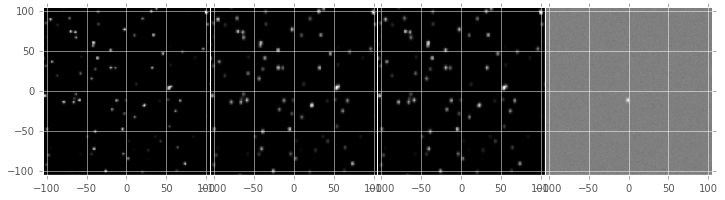

In [16]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit, mode='constant')
fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10)) # diffim (grey)
print scipy.stats.describe(im2 - conv_im1, axis=None)

Create the $b_i$ and $M_{ij}$ from the A&L (1998) and Becker (2012) papers. This was done wrong in the previous version of notebook 3 (and above), although it gives identical results.

(121,)
(121, 121)
[ -7.04318647e-01   3.15311237e-02  -1.58489696e-01   9.22191927e-03
  -1.20923427e-02  -1.58683504e-01  -1.19825615e-01   8.34132013e-01
   1.66275295e-02   2.73456696e-03  -4.98619629e-02   5.33430734e-02
  -3.47305895e-02   2.91635106e-04  -2.53549017e-03  -1.67165808e-02
  -2.46148904e-02   6.38266783e-02  -2.58899245e-04  -4.25727728e-04
  -3.23072326e-03   3.61230718e-03  -3.33199163e-03  -1.06011972e-04
   4.66745313e-05   2.23307243e-01   6.76040232e-02  -1.12158980e-01
   7.25423007e-02   3.03622274e-01  -7.85334698e-01  -9.64430011e-02
  -7.54860678e-02   1.88615171e-02  -8.23381486e-03  -1.15630014e-02
   2.84654660e-02  -1.44026703e-03   2.21408262e-03  -7.90800899e-04
   3.69892475e-01   5.27153778e-02  -2.51739151e-02  -2.54543397e-01
   6.35079822e-02  -1.92971773e-01   2.97862756e-02  -1.07772431e-02
   5.17002025e-03  -3.09595895e-04  -4.35169828e-04   1.14420602e-03
   5.44443597e-05   5.42538054e-05   8.78083305e-06   2.13757809e-01
  -8.83857511e-0

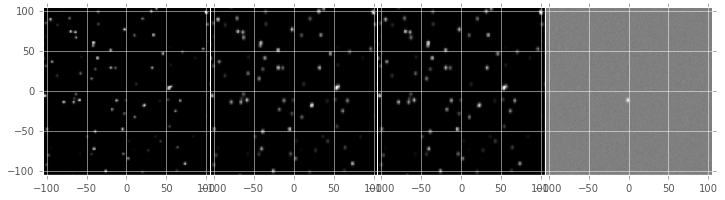

In [17]:
b = (basis2a.T * im2.flatten()).sum(1)
print b.shape

M = np.dot(basis2a.T, basis2a)
print M.shape

pars2, resid, _, _ = np.linalg.lstsq(M, b)
print pars2
#print 'Difference (log10):\n', np.log10(np.abs((pars2-pars)/pars2))

fit2 = (pars2 * basis2a).sum(1).reshape(im1.shape)
print basis2a.shape, fit2.shape

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow((im2 - fit2)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10))
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit2, axis=None)
#print pars2-pars

(121,) (961, 121)
0.999986426317


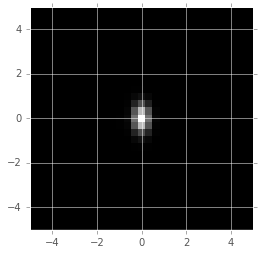

In [18]:
kbasis = np.vstack([b.flatten() for b in basis]).T
print pars2.shape, kbasis.shape
kfit2 = (pars2 * kbasis).sum(1).reshape(basis[0].shape)
print kfit2.sum()
kfit2 /= kfit2.sum()  # this is necessary if the variable source changes a lot - prevent the kernel from incorporating that change in flux
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(kfit2, extent=extent, interpolation='none', cmap='gray')  # this plots the matching kernel

(511, 511) -0.236733158951 2404.7636768
DescribeResult(nobs=261121, minmax=(7.3143666015134644e-14, 2248510.891658185), mean=3070.5228030663943, variance=1221403813.0577335, skewness=21.030844933733718, kurtosis=568.1216699065716)
DescribeResult(nobs=261121, minmax=(3.0864645359988265e-14, 79.351651975517242), mean=0.04579884926793569, variance=0.11503500912375972, skewness=156.87296606648465, kurtosis=28523.48007304263)
DescribeResult(nobs=261121, minmax=(-0.89409145231462606, 8.9079544214997668), mean=-1.6871144476001202e-05, variance=0.045799024377176478, skewness=1.6603944701068614, kurtosis=52.843275774325726)


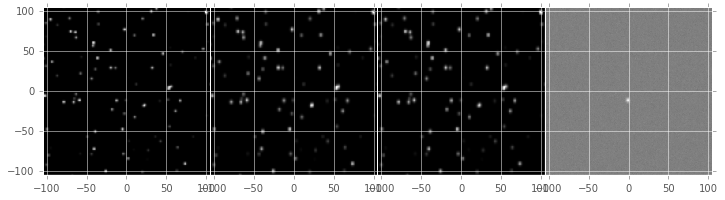

In [19]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit2, mode='constant')
print conv_im1.shape, conv_im1.min(), conv_im1.max()
print scipy.stats.describe((im2 - im1)**2, axis=None)
print scipy.stats.describe((im2 - conv_im1)**2, axis=None)

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10)) # diffim (grey)
print scipy.stats.describe(im2 - conv_im1, axis=None)

Add taking into account PSF variations... (next notebook, #4)

## Compute the "L(ZOGY)" post-conv. kernel from kfit

1.38769661908
-0.0438882764537
1.0


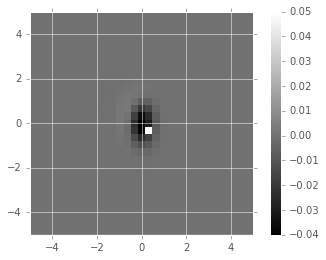

In [20]:
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift

def kernel_ft2(kernel):
    FFT = fft2(kernel)
    return FFT
def post_conv_kernel_ft2(kernel, sig1=1., sig2=1.):
    kft = kernel_ft2(kernel)
    return np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))
def post_conv_kernel2(kernel, sig1=1., sig2=1.):
    kft = post_conv_kernel_ft2(kernel, sig1, sig2)
    out = ifft2(kft)
    return out

pck = post_conv_kernel2(kfit, sig1=sig2, sig2=sig1)
print pck.real.max()
print pck.real.min()
print pck.real.sum()
pck = np.fft.ifftshift(pck.real)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(pck, extent=extent, interpolation='none', cmap='gray', clim=(-0.04,0.05))  # this plots the matching kernel
plt.colorbar()

### I think we actually need to "reverse" the PSF, as in the ZOGY (and Kaiser) papers... let's try it.

This is the same as taking the complex conjugate in Fourier space before FFT-ing back to real space.

1.38769661908
-0.0438882764537
1.0


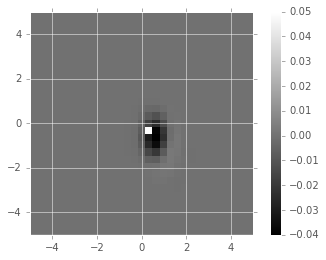

In [21]:
def post_conv_kernel2a(kernel, sig1=1., sig2=1.):
    kft = post_conv_kernel_ft2(kernel, sig1, sig2)
    kft = np.conj(kft)
    out = ifft2(kft)
    return out

pck = post_conv_kernel2a(kfit, sig1=sig2, sig2=sig1)
print pck.real.max()
print pck.real.min()
print pck.real.sum()
pck = np.fft.ifftshift(pck.real)

# I still think we need to flip it in one axis (TBD: figure this out!)
#pck = pck[::-1,:]

extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(pck, extent=extent, interpolation='none', cmap='gray', clim=(-0.04,0.05))  # this plots the matching kernel
plt.colorbar()

## Now convolve the image difference with the kernel.

1.0 1.38769661908 -0.0438882764537
DescribeResult(nobs=261121, minmax=(-1.236517295722799, 10.291403724873378), mean=-1.1978722285188276e-05, variance=0.085067165943109313, skewness=0.9623372255999404, kurtosis=26.651711689566945)
DescribeResult(nobs=261121, minmax=(-0.89409145231462606, 8.9079544214997668), mean=-1.6871144476001202e-05, variance=0.045799024377176478, skewness=1.6603944701068614, kurtosis=52.843275774325726)


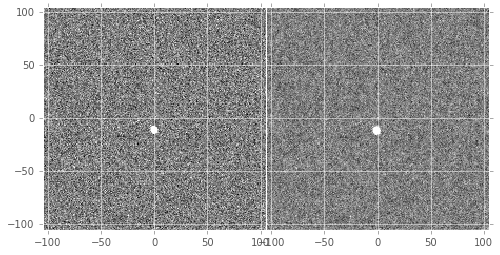

In [22]:
print pck.sum(), pck.max(), pck.min()
#pck /= pck.sum()
pci = scipy.ndimage.filters.convolve(im2-conv_im1, pck, mode='constant')

fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(pci[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1)) # corrected diffim
igrid[1].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-1,1)) # original diffim
print scipy.stats.describe(pci, axis=None)
print scipy.stats.describe(im2 - conv_im1, axis=None)

-0.998044780775 0.996940605322
Corrected: -0.000558238413537 0.285045896575
Original:  -0.000576836734247 0.20764965175
Expected:  0.282842712475


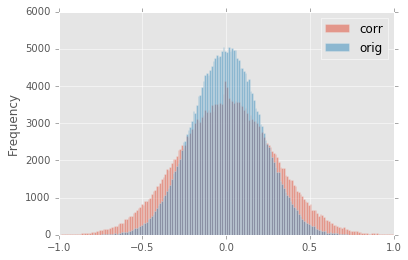

In [23]:
import pandas as pd
#df = pd.DataFrame({'corr': pci.flatten(), 'orig': (im2-conv_im1).flatten()})
#df.plot.hist(alpha=0.5, bins=200)

_, low, upp = scipy.stats.sigmaclip([pci, im2-conv_im1])
print low, upp
tmp1a = pci[(pci>low) & (pci<upp) & (im2-conv_im1>low) & (im2-conv_im1<upp)]
tmp2a = (im2-conv_im1)[(pci>low) & (pci<upp) & (im2-conv_im1>low) & (im2-conv_im1<upp)]
df = pd.DataFrame({'corr': tmp1a.flatten(), 'orig': tmp2a.flatten()})
df.plot.hist(alpha=0.5, bins=200)

print 'Corrected:', np.mean(tmp1a), np.std(tmp1a)
print 'Original: ', np.mean(tmp2a), np.std(tmp2a)
print 'Expected: ', np.sqrt(sig1**2 + sig2**2)

## Compute the (corrected) diffim's new PSF

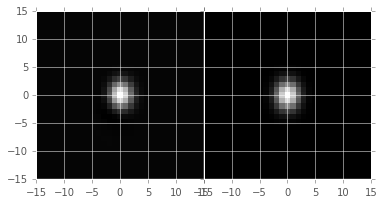

In [24]:
# post_conv_psf = phi_1(k) * sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
# we'll parameterize phi_1(k) as a gaussian with sigma "psfsig1".

def kernel_ft2(kernel):
    FFT = fft2(kernel)
    return FFT
def post_conv_psf_ft2(psf, kernel, sig1=1., sig2=1.):
    psf_ft = kernel_ft2(psf)
    kft = kernel_ft2(kernel)
    out = psf_ft * np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))
    return out
def post_conv_psf(psf, kernel, sig1=1., sig2=1.):
    kft = post_conv_psf_ft2(psf, kernel, sig1, sig2)
    out = ifft2(kft)
    return out

# First compute the science image's (im2's) psf -- easy since we parameterized it above when we made the image
im2_psf = gaussian2d(grid, m=[0, 0], s=[psf2, psf2*1.5])

pcf = post_conv_psf(psf=im2_psf, kernel=kfit, sig1=sig2, sig2=sig1)
pcf = pcf.real / pcf.real.sum()

fig = plt.figure(1, (6, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0)
extent = (x0.min(), x0.max(), y0.min(), y0.max())
gim = igrid[0].imshow(pcf, origin='lower', interpolation='none', cmap='gray', extent=extent) #, clim=(-0.01,0.01)) # corrected psf
igrid[1].imshow(im2_psf, origin='lower', interpolation='none', cmap='gray', extent=extent) #, clim=(-0.01,0.01)) # original psf

Look at how detection would compare in the new diffim vs. the original one by convolving them with their psfs.

In [25]:
tmp1 = scipy.ndimage.filters.convolve(pci, pcf, mode='constant')
#plt.plot(xim, tmp1)  # red - corrected
tmp2 = scipy.ndimage.filters.convolve(im2-conv_im1, im2_psf, mode='constant')
#plt.plot(xim, tmp2)  # blue - original

Detect 5-$\sigma$ sources. First compute stats on the convolved diffim's.

-0.201342554182 0.200164417718
0.345551756446 0.290293850395
76 93
0.275302573261 0.224330342087
1: 81 -15 -5 1.85412953293 0.279416731916 5.61420578752
2: 102 -17 -5 1.44546723479 0.227029071358 4.5372201533


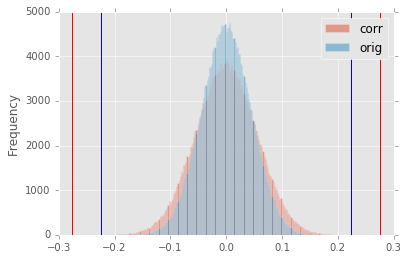

In [26]:
#df = pd.DataFrame({'corr': tmp1.flatten(), 'orig': tmp2.flatten()})
#df.plot.hist(alpha=0.5, bins=200)

_, low, upp = scipy.stats.sigmaclip([tmp1, tmp2])
print low, upp
tmp1a = tmp1[(tmp1>low) & (tmp1<upp) & (tmp2>low) & (tmp2<upp)]
tmp2a = tmp2[(tmp1>low) & (tmp1<upp) & (tmp2>low) & (tmp2<upp)]
df = pd.DataFrame({'corr': tmp1a.flatten(), 'orig': tmp2a.flatten()})
df.plot.hist(alpha=0.5, bins=200)

print tmp1.std()*5., tmp2.std()*5.
print np.sum(np.abs(tmp1) > tmp1.std()*5.), np.sum(np.abs(tmp2) > tmp2.std()*5.)

import scipy.stats
tmp1a, low, upp = scipy.stats.sigmaclip(tmp1)
tmp2a, low, upp = scipy.stats.sigmaclip(tmp2)
print tmp1a.std()*5., tmp2a.std()*5.

det1 = x0im[np.abs(tmp1) > tmp1a.std()*5.]
src1 = tmp1[np.abs(tmp1) > tmp1a.std()*5.]
det2 = x0im[np.abs(tmp2) > tmp2a.std()*5.]
src2 = tmp2[np.abs(tmp2) > tmp2a.std()*5.]
if len(det1) > 0: 
    print '1:', len(det1), det1.min(), det1.max(), src1.mean(), src1.min(), src1.max()
else:
    print '1:', len(det1)
    
if len(det2) > 0:
    print '2:', len(det2), det2.min(), det2.max(), src2.mean(), src2.min(), src2.max()
else:
    print '2:', len(det2)

xaxs = np.linspace(df.min()[0], df.max()[0])
#plt.plot(xaxs, 200*gaussian(xaxs, s=tmp1a.std()), color='r')
#plt.plot(xaxs, 200*gaussian(xaxs, s=tmp2a.std()), color='b')
plt.plot(np.repeat(tmp1a.std()*5., 2), [-0, 5000], color='r')
plt.plot(np.repeat(-tmp1a.std()*5., 2), [-0, 5000], color='r')
plt.plot(np.repeat(tmp2a.std()*5., 2), [-0, 5000], color='b')
plt.plot(np.repeat(-tmp2a.std()*5., 2), [-0, 5000], color='b')

Dump the results for comparison with ZOGY in notebook #13.

In [27]:
import cPickle
import gzip
im1_psf = gaussian2d(grid, m=[0, 0], s=[psf1, psf1])
cPickle.dump((im1, im2, im1_psf, im2_psf, conv_im1, pci, pcf), gzip.GzipFile("11_results.p.gz", "wb"))